Copyright Preferred Networks, Inc. as contributors to Matlantis contrib project

## Evaluating Free Energy Surfaces (FES)
Free energy is one of the most important physical quantities that determine the physicochemical properties of matter.
The variable of interest, such as the positional relationship of molecules, is called the collective variable (CV) or reaction coordinate,
The function of the free energy with respect to CVs is called a free energy surface.
By calculating the free energy surface of an interesting reaction,
one can determine the activation free energy of the reaction as well as the strength of the interactions between the molecules involved.

This Notebook provides a tutorial on Matlantis to evaluate free energy surfaces for [radical addition reactions](https://polymerdatabase.com/polymer%20chemistry/radical%20polymerization.html),
including the polymerization of methyl methacrylate (MMA), by using metadynamics simulation.

## Metadynamics simulation
Various methods have been proposed for evaluating free energy surfaces, and new methods continue to be actively developed.
In this Notebook, we utilize one of the standard methods, the well-tempered metadynamics.
When evaluating free energy surfaces using molecular dynamics (MD) simulations,
sampling is typically concentrated around the stable points, making it difficult to achieve sampling between these points.
Metadynamics can overcome this limitation by encouraging exploration of the free energy surface through the addition of external potentials that depend on time and CVs.

## Requirements
Although there are various software packages that can be used for metadynamics, this Notebook will demonstrate the method using LAMMPS and PLUMED.
To ensure the proper execution of the Notebook, LAMMPS and PLUMED must be installed beforehand.
You can find the installation instructions for both LAMMPS and PLUMED on Maltntis under Launchers -> Packages -> matlantis-lammps.
This Notebook assumes that LAMMPS is correctly installed and that PLUMED is installed in the directory `/home/jovyan/local`.

In [1]:
import glob
import os
import subprocess as sub
from tempfile import NamedTemporaryFile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pfp_api_client
from ase import Atoms
from ase.constraints import Hookean
from ase.io import write
from ase.optimize import LBFGS
from ase.units import kB, kcal, mol
from pfcc_extras.structure.ase_rdkit_converter import smiles_to_atoms
from pfcc_extras.visualize.view import view_ngl
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator, EstimatorCalcMode

PLUMED_PATH = "/home/jovyan/local"
env = os.environ.copy()
env["PATH"] = ":".join([os.environ.get("PATH"), PLUMED_PATH + "/bin"])
env["LD_LIBRARY_PATH"] = ":".join(
    [os.environ.get("LD_LIBRARY_PATH"), PLUMED_PATH + "/lib"]
)

/home/jovyan/.py38/lib/python3.8/site-packages/pfp_api_client/__init__.py:35: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(


## Creating the initial structure
First, model the methyl methacrylate (MMA) radical, MMA.

In [2]:
e1 = smiles_to_atoms("C[C](C)C(=O)OC")
e1.positions += [-4, 0, 0]
e2 = smiles_to_atoms("CC(=C)C(=O)OC")
e2.positions += [4, 0, 0]
atoms = e1 + e2
atoms.set_cell([20, 20, 20])
atoms.set_pbc(True)
atoms.positions += [10, 10, 10]
view_ngl(atoms, representations=["ball+stick"], w=400, h=300)

## Selecting CV and adjusting its initial value
In metadynamics, a simulation is conducted using biased potentials applied along certain collective variables (CVs).
The radical addition reaction that we will simulate in this tutorial is a simple one that forms a covalent bond between two carbon atoms.
Typical covalent bond distances are a little over 1 &nbsp;&Aring;, and the distance at which a bond can be considered to have been cleaved is usually at most 5 &nbsp;&Aring;.
Therefore, the range of reaction coordinates for the simulation is within this range.

In order to obtain an appropriate initial structure for the metadynamics simulations, we adjust the CV to be within this range.
Specifically, the CV used in this tutorial is the distance $d$ between the carbon radical on MMA (indexed as 1) and the carbon atom on MMA (indexed as 18).
The optimization is performed with the harmonic potential for constraint added so that the initial value of CV is around $d$=2.

### Note: selection of CVs
Metadynamics is generally sensitive to the choice of CVs and their search ranges.
Although only one CV is selected for simplicity in this tutorial,
keep in mind that careful consideration of CVs and the dependence of FES on the choice of CVs is necessary to correctly evaluate FES.

In [3]:
estimator = Estimator(
    calc_mode=EstimatorCalcMode.CRYSTAL_PLUS_D3, model_version="v4.0.0"
)
calculator = ASECalculator(estimator)
atoms.calc = calculator
c_cc = Hookean(a1=1, a2=18, rt=2.0, k=0.5)
atoms.set_constraint([c_cc])
opt = LBFGS(atoms, logfile="output/min.log")
opt.run(fmax=0.01)
view_ngl(atoms, representations=["ball+stick"], w=400, h=300)

## Export ASE Atoms to LAMMPS data file
Export the structure created by ASE in LAMMPS data format.

In [4]:
filename = "input/mma-radical-addition.data"
write(filename, atoms, format="lammps-data")

## Creating the LAMMPS Input File
Create a LAMMPS input file for the simulation.
There are two ways to perform metadynamics simulations in LAMMPS: using the COLVARS package or by using the PLUMED package.
When using the PLUMED package, you can apply CVs and bias potentials using the LAMMPS command `fix plumed`.
The settings for PLUMED are specified in a separate file (in this case, `input/plumed.dat`).

In [5]:
lmp_in = """
units metal
boundary p p p
atom_style atomic
atom_modify map yes
read_data input/mma-radical-addition.data

mass 1 12.011
mass 2 1.008
mass 3 15.999

pair_style pfp_api v4.0.0 CRYSTAL_PLUS_D3
pair_coeff * * species C H O

timestep 0.001

thermo 1000
thermo_style custom step temp etotal pe ke lx vol press density

dump 1 all custom 1000 output/metadynamics.lammpstrj id type element x y z vx vy vz fx fy fz
dump_modify 1 element C H O

velocity all create 300 12345 dist gaussian mom yes
fix f1 all nvt temp 300 300 0.1
fix f2 all plumed plumedfile input/plumed.dat outfile output/plumed.log

run 500000
unfix f1
unfix f2
"""

with open("input/metadynamics.in", "w") as fo:
    fo.write(lmp_in)

## Creating the PLUMED Configuration File
Create a configuration file for metadynamics.
The main settings are described below:

- `d1: DISTANCE ATOMS=2,19`
    - Defines the two atoms that will act as the CV.
    - The radical carbon on MMA radical (index=1 in ASE) and carbon on MMA (index=18 in ASE) are set as population variables.
    - Note that in ASE, atomic indices start at 0, while in LAMMPS and PLUMED, the indices start at 1!
- `metad: METAD ARG=d1 SIGMA=0.2 HEIGHT=0.02 PACE=200 TEMP=300 GRID_MIN=0.5 GRID_MAX=6 GRID_BIN=100 BIASFACTOR=20 CALC_RCT FILE=output/HILLS`
    - Metadynamics Bias Conditions
        - ARG: The CV that will add the bias potential
        - SIGMA: Width of the bias set to 0.2 &nbsp;&Aring;
        - HEIGHT: Initial height of the bias set to 0.02 eV
        - PACE: The bias is added every 200 steps
        - BIASFACTOR: use well tempered metadynamics and use this bias factor.
        - CALC_RCT: Calculate the reweighting factor
- `uwall: UPPER_WALLS ARG=d1 AT=5 KAPPA=20 EXP=4 EPS=1 OFFSET=0`
    - Sets the upper limit of the CV to 5 &nbsp;&Aring; to prevent the molecules from drifting apart to infinity.

Metadynamics simulations have diverse conditions, and it is noteworthy that some variables,
such as the choice of collective variables, may significantly impact the simulation results.
See [PLUMED documents](https://www.plumed.org/doc-v2.8/user-doc/html/_m_e_t_a_d.html) for configuration details.

In [6]:
plumed_in = """
UNITS LENGTH=A ENERGY=eV
d1: DISTANCE ATOMS=2,19
metad: METAD ARG=d1 SIGMA=0.2 HEIGHT=0.02 PACE=200 TEMP=300 GRID_MIN=0.5 GRID_MAX=6 GRID_BIN=100 BIASFACTOR=20 CALC_RCT FILE=output/HILLS
uwall: UPPER_WALLS ARG=d1 AT=5 KAPPA=20 EXP=4 EPS=1 OFFSET=0
PRINT ARG=* STRIDE=100 FILE=output/COLVARS
"""

with open("input/plumed.dat", "w") as fo:
    fo.write(plumed_in)

## Run the simulation
Run the simulation, which will take about 10 hours on Matlantis due to the relatively long sampling time of 500 ps.

In [7]:
!lmp_serial -i input/metadynamics.in -log output/metadyn.log

LAMMPS (29 Sep 2021 - Update 3)
Reading data file ...
  orthogonal box = (0.0000000 0.0000000 0.0000000) to (20.000000 20.000000 20.000000)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  31 atoms
  read_data CPU = 0.000 seconds
/home/jovyan/.py38/lib/python3.8/site-packages/pfp_api_client/__init__.py:35: UserWarning: New version of pfp-api-client is available. Please consider upgrading by `pip install -U pfp-api-client`.
  warnings.warn(
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 2.01
  ghost atom cutoff = 2.01
  binsize = 1.005, bins = 20 20 20
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair pfp_api, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocatio

## Calculation of FES
When the calculation is successfully completed, several files are generated in the `output` directory.
In particular, the following files are outputs specific to metadynamic simulation.

- HILLS: Information on potentials added during metadynamics
- COLVARS: information on CVs and external biases during the simulation

FES can be calculated from these files.
There are two ways to obtain FES by external bias.

1. Sum the potentials added by sum_hills
2. Calculate from the probability of CVs reweighted by external bias

In this example, we will try to construct the FES using both methods.

## Calculating FES by sum_hills
In a metadynamics simulation, bias potentials are added at each time step to fill the valleys in the free energy surface (FES).
After a certain simulation time, the sum of the bias potentials added corresponds roughly to the shape of the FES.
PLUMED provides the command sum_hills as a means of calculating the sum of the bias potentials.
In the following code, the `HILLS` obtained for the entire simulation is split into separate `HILLS` for each simulation time, and `sum_hills` is run.

In [8]:
def run_sumhills_time_splitted(
    hills_path, temp, env=env, nsplit=5, output_dir="output"
):
    with open(hills_path, "r") as f:
        hills = f.readlines()
        total_hills = len([line for line in hills if not line.startswith("#!")])
        len_header = len(hills) - total_hills

    num_hills = [int(total_hills * ((i + 1) / nsplit)) for i in range(nsplit)]
    for n in num_hills:
        h = hills[: len_header + n]
        t = h[-1].split()[0]

        with open(f"{output_dir}/HILLS-{t}", "w") as fo:
            for line in h:
                fo.write(line)
            sub.run(
                (
                    f"plumed sum_hills --hills {output_dir}/HILLS-{t} "
                    f"--outfile {output_dir}/sumhills-{t}ps.dat --kt {temp*kB} --mintozero"
                ),
                shell=True,
                env=env,
            )

In [9]:
run_sumhills_time_splitted(hills_path="output/HILLS", temp=300, env=env)

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.5 (git: 6e73352f7) compiled on May  9 2023 at 05:39:21
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/jovyan/local/lib/plumed
PLUMED: For installed feature, see /home/jovyan/local/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished setup
PLUMED: Action FAKE
PLUMED:   with l

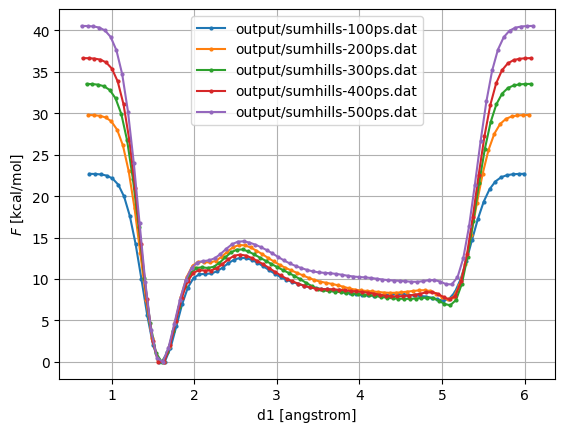

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
fesfiles = sorted(glob.glob("output/sumhills-*ps.dat"))
for fesfile in fesfiles:
    fes = pd.read_csv(
        fesfile,
        sep="\s+",
        skiprows=5,
        header=None,
        names=["d1", "file.free", "der_rxn1"],
    )
    ax.plot(fes["d1"], fes["file.free"] * mol / kcal, marker="o", ms=2, label=fesfile)
    ax.set_xlabel("d1 [angstrom]")
    ax.set_ylabel(r"$F$ [kcal/mol]")
    ax.legend()
    ax.grid(True)

## Calculating FES by Reweighting Collective Variables
In the previous example, we obtained the activation free energy by summing the biases added as external potentials.
Alternatively, it is possible to evaluate the free energy surface (FES) by re-weighting the probability distribution of collective variables.
The probability distribution $P(s)$ of a collective variable $s$ is related to the free energy $F(s)$ by the following equation:

$$
F(s) = -k_bT\mathrm{log}P(s)
$$

Here, $k_b$ is the Boltzmann constant, and $T$ is the temperature. The probability distribution obtained in a metadynamics simulation is under the influence of biases. To evaluate the FES using the above equation, it is necessary to obtain the probability distribution under unbiased conditions.
The `COLVARS` file produced by this simulation records the biases imposed during the sampling of each collective variable (CV).
By re-weighting the samples using these biases, it is possible to obtain the unbiased probability distribution. This approach is similar to the Weighted Histogram Analysis Method (WHAM) used in umbrella sampling.
In practice, the weight $W(R)$ of a given configuration $\mathbf{R}$ can be calculated using the following equation that incorporates external potentials:

$$
w(R) = e^{\beta(V(s,t)-c(t)+V_{wall}(s))}
$$

Here, $V(s,t)$ is the potential at time $t$ of the collective variable $s$, $c(t)$ is the re-weighting factor, and $V_{wall}(s)$ denotes the potential resulting from the wall.
The following code evaluates the FES using re-weighting. Note that we exclude the first 300 ps from the analysis to sample only after the system has reached a quasi-steady state.

In the following example, the FES error bars are calculated by computing the block average.
It is also known that the number of blocks should be large enough to eliminate time correlation within each block.
For more information, please also refer to the following URL

- https://github.com/plumed/masterclass-21-2
- https://www.plumed.org/doc-v2.8/user-doc/html/lugano-4.html

In [11]:
def calc_fes_reweight(colvars_path, temp, cv, nbins=100, nblocks=5, skipframes=3000):

    with open(colvars_path, "r") as f:
        header = [s.rstrip("\n") for s in f.readline().split(" ")[2:]]
    colvars = pd.read_csv(
        colvars_path, header=None, sep="\s+", skiprows=1, names=header
    )
    colvars["weight"] = np.exp(
        (colvars["metad.bias"] - colvars["metad.rct"] + colvars["uwall.bias"])
        / (kB * temp)
    )
    colvars = colvars[skipframes:]
    colvars["block"] = pd.cut(
        colvars["time"], bins=nblocks, labels=[f"b{i}" for i in range(1, nblocks + 1)]
    )

    df = pd.DataFrame()

    for i, block in enumerate(colvars["block"].unique()):
        grouped = colvars[colvars["block"] == block]
        hist, bin_edges = np.histogram(
            grouped[cv], bins=nbins, weights=grouped["weight"], range=(0.5, 6)
        )
        if not "bin_centers" in df.columns:
            df["bin_centers"] = (bin_edges[1:] + bin_edges[:-1]) / 2
        df[f"block{i}"] = hist

    hists = df.iloc[:, df.columns != "bin_centers"]
    ste = hists.std(axis=1) / np.sqrt(nblocks)
    mean = hists.mean(axis=1)

    df["fes_mean"] = -np.log(mean)
    df["fes_mean"] -= df["fes_mean"].min()
    df["fes_CI_lower"] = df["fes_mean"] - 2 * ste / mean
    df["fes_CI_upper"] = df["fes_mean"] + 2 * ste / mean
    df[["fes_mean", "fes_CI_lower", "fes_CI_upper"]] *= kB * temp * mol / kcal

    return df

In [12]:
df = calc_fes_reweight(colvars_path="output/COLVARS", temp=300, cv="d1")

/home/jovyan/.py38/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Finally, we compare the FES calculated by re-weighting with the one obtained by summing hills. We can see that similar FES are obtained with sumhills and reweighting. The difference between the two depends on the number of samples and other factors.

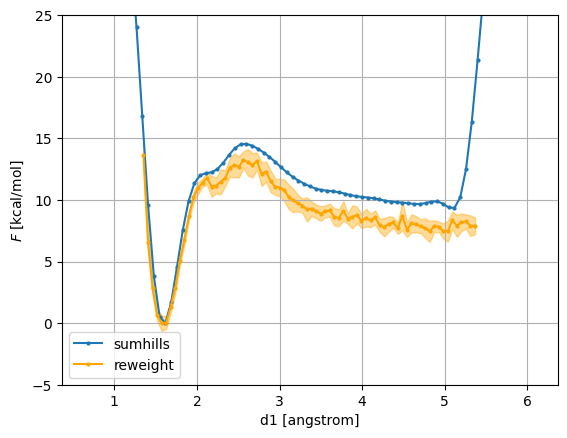

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

fes = pd.read_csv(
    "output/sumhills-500ps.dat",
    sep="\s+",
    skiprows=5,
    header=None,
    names=["d1", "file.free", "der_rxn1"],
)
ax.plot(fes["d1"], fes["file.free"] * mol / kcal, marker="o", ms=2, label="sumhills")

ax.fill_between(
    df["bin_centers"], df["fes_CI_lower"], df["fes_CI_upper"], alpha=0.4, color="orange"
)
ax.plot(
    df["bin_centers"],
    df["fes_mean"],
    label="reweight",
    marker="o",
    ms=2,
    color="orange",
)

ax.set_ylim(-5, 25)
ax.set_xlabel("d1 [angstrom]")
ax.set_ylabel(r"$F$ [kcal/mol]")
ax.legend()
ax.grid(True)